In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertConfig

class MusicBERTSimilarity(nn.Module):
    def __init__(self, vocab_size=5000):
        super(MusicBERTSimilarity, self).__init__()

        config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=768,
            num_hidden_layers=4,        # 실험용으로 작게
            num_attention_heads=8,
            intermediate_size=1024,
            max_position_embeddings=512,
            type_vocab_size=2,
            pad_token_id=0
        )

        self.encoder = BertModel(config)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 1)  # 이진 분류용
        )

    def forward(self, input_ids_a, input_ids_b, attention_mask_a, attention_mask_b):
        # 각 시퀀스를 개별적으로 BERT에 통과
        output_a = self.encoder(input_ids=input_ids_a, attention_mask=attention_mask_a).last_hidden_state[:, 0, :]  # CLS
        output_b = self.encoder(input_ids=input_ids_b, attention_mask=attention_mask_b).last_hidden_state[:, 0, :]  # CLS

        # 두 CLS 벡터를 이어붙임
        combined = torch.cat([output_a, output_b], dim=1)
        combined = self.dropout(combined)

        # 최종 유사도 score 출력
        logits = self.classifier(combined)
        return logits  # (batch_size, 1)

if __name__ == "__main__":
    model = MusicBERTSimilarity(vocab_size=1000)  # 실험용으로 vocab 축소
    model.eval()

    # 예시 입력: batch_size=3, seq_len=6
    ids_a = torch.randint(100, 500, (3, 6))
    ids_b = torch.randint(100, 500, (3, 6))
    mask_a = (ids_a != 0).long()
    mask_b = (ids_b != 0).long()

    labels = torch.tensor([[1], [0], [1]]).float()  # 1=유사, 0=다름

    with torch.no_grad():
        logits = model(ids_a, ids_b, mask_a, mask_b)
        loss = F.binary_cross_entropy_with_logits(logits, labels)
        preds = (torch.sigmoid(logits) > 0.5).long()
        acc = (preds == labels.long()).float().mean()

    print("Loss:", loss.item())
    print("Accuracy:", acc.item())
    print("Logits:", logits.squeeze().tolist())


Loss: 0.6768158078193665
Accuracy: 0.6666666865348816
Logits: [0.04499111324548721, 0.16763165593147278, 0.24286088347434998]


In [ ]:
# 🔧 설치 필요
!pip install transformers miditoolkit

# ✅ 모델 정의
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertConfig
import miditoolkit

class MusicBERTSimilarity(nn.Module):
    def __init__(self, vocab_size=512):
        super(MusicBERTSimilarity, self).__init__()
        config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=768,
            num_hidden_layers=4,
            num_attention_heads=8,
            intermediate_size=1024,
            max_position_embeddings=512,
            type_vocab_size=2,
            pad_token_id=0
        )
        self.encoder = BertModel(config)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, input_ids_a, input_ids_b, attention_mask_a, attention_mask_b):
        output_a = self.encoder(input_ids=input_ids_a, attention_mask=attention_mask_a).last_hidden_state[:, 0, :]
        output_b = self.encoder(input_ids=input_ids_b, attention_mask=attention_mask_b).last_hidden_state[:, 0, :]
        combined = torch.cat([output_a, output_b], dim=1)
        combined = self.dropout(combined)
        logits = self.classifier(combined)
        return logits

# 🧩 MIDI를 pitch 시퀀스로 변환
def midi_to_token_sequence(filepath, max_length=512):
    midi_obj = miditoolkit.midi.parser.MidiFile(filepath)
    notes = []
    for track in midi_obj.instruments:
        if track.is_drum:
            continue
        for note in track.notes:
            notes.append((note.start, note.pitch))
    notes.sort()
    tokens = [pitch for _, pitch in notes]
    if len(tokens) > max_length:
        tokens = tokens[:max_length]
    else:
        tokens += [0] * (max_length - len(tokens))
    input_ids = torch.tensor(tokens).unsqueeze(0)  # (1, seq_len)
    attention_mask = (input_ids != 0).long()
    return input_ids, attention_mask

# 📂 Colab에 파일 업로드
from google.colab import files
uploaded = files.upload()

# 🔍 파일 경로 설정
file1 = "Queen - Bohemian Rhapsody.mid"
file2 = "Never-Gonna-Give-You-Up-3.mid"

# 🧠 모델 준비 및 비교
model = MusicBERTSimilarity(vocab_size=512)
model.eval()

input_ids_a, mask_a = midi_to_token_sequence(file1)
input_ids_b, mask_b = midi_to_token_sequence(file2)

with torch.no_grad():
    logits = model(input_ids_a, input_ids_b, mask_a, mask_b)
    score = torch.sigmoid(logits).item()
    print(f"🎼 Similarity score: {score:.4f} (0=다름, 1=유사)")


Saving Never-Gonna-Give-You-Up-3.mid to Never-Gonna-Give-You-Up-3 (2).mid
Saving Queen - Bohemian Rhapsody.mid to Queen - Bohemian Rhapsody (1).mid
🎼 Similarity score: 0.5203 (0=다름, 1=유사)


In [ ]:
# 🔧 설치 필요 (최초 1회만)
!pip install transformers miditoolkit scikit-learn matplotlib

# ✅ 필요 모듈
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertConfig, BertModel
import miditoolkit
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 🧠 모델 정의 (Cosine 기반 유사도)
class MusicBERTEmbedding(nn.Module):
    def __init__(self, vocab_size=6000):
        super().__init__()
        config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=768,
            num_hidden_layers=4,
            num_attention_heads=8,
            intermediate_size=1024,
            max_position_embeddings=512,
            type_vocab_size=2,
            pad_token_id=0
        )
        self.encoder = BertModel(config)

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        return output.last_hidden_state[:, 0, :]  # CLS vector

# 🧩 MIDI -> REMI 스타일 토큰 시퀀스 변환
def midi_to_remi_tokens(filepath, max_length=512):
    midi_obj = miditoolkit.midi.parser.MidiFile(filepath)
    events = []
    for track in midi_obj.instruments:
        if track.is_drum:
            continue
        for note in track.notes:
            start = min(int(note.start // 10), 999)              # 0~999
            duration = min(int((note.end - note.start) // 10), 999)  # 0~999
            pitch = note.pitch                                   # 0~127
            velocity = min(note.velocity, 127)                   # 0~127
            events.append((start, duration, pitch, velocity))
    events.sort()

    tokens = []
    for start, duration, pitch, velocity in events:
        tokens.append(1000 + start)      # Time (1000–1999)
        tokens.append(2000 + duration)   # Duration (2000–2999)
        tokens.append(3000 + pitch)      # Pitch (3000–3127)
        tokens.append(4000 + velocity)   # Velocity (4000–4127)

    if len(tokens) > max_length:
        tokens = tokens[:max_length]
    else:
        tokens += [0] * (max_length - len(tokens))

    input_ids = torch.tensor(tokens).unsqueeze(0)
    attention_mask = (input_ids != 0).long()
    return input_ids, attention_mask


# 🔍 Cosine 유사도 계산
def cosine_similarity(vec1, vec2):
    return F.cosine_similarity(vec1, vec2).item()

# 📈 시각화 (Embedding 공간)
def visualize_embeddings(embeddings, labels):
    reduced = TSNE(n_components=2).fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(set(labels)):
        idx = [j for j, l in enumerate(labels) if l == label]
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=label)
    plt.legend()
    plt.title("MIDI Embedding Space (t-SNE)")
    plt.show()

# 📂 Colab에서 파일 업로드
from google.colab import files
uploaded = files.upload()

# 🔍 파일 경로 설정
file1 = "Queen - Bohemian Rhapsody.mid"
file2 = "Never-Gonna-Give-You-Up-3.mid"

# 🧠 모델 생성
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MusicBERTEmbedding(vocab_size=5000).to(device)

model.eval()

# 🎵 MIDI 임베딩 생성
input_ids_a, mask_a = midi_to_remi_tokens(file1)
input_ids_b, mask_b = midi_to_remi_tokens(file2)

input_ids_a, mask_a = input_ids_a.to(device), mask_a.to(device)
input_ids_b, mask_b = input_ids_b.to(device), mask_b.to(device)

with torch.no_grad():
    vec_a = model(input_ids_a, mask_a)
    vec_b = model(input_ids_b, mask_b)
    score = cosine_similarity(vec_a, vec_b)

print(f"🎼 유사도 점수 (Cosine): {score:.4f} (0 = 다름, 1 = 유사)")

# (선택) 여러 MIDI의 임베딩을 시각화하고 싶을 때 사용
# example:
# embeddings = [vec_a.squeeze().cpu().numpy(), vec_b.squeeze().cpu().numpy()]
# labels = ["Bohemian", "RickRoll"]
# visualize_embeddings(embeddings, labels)


Saving Never-Gonna-Give-You-Up-3.mid to Never-Gonna-Give-You-Up-3 (4).mid
Saving Queen - Bohemian Rhapsody.mid to Queen - Bohemian Rhapsody (3).mid
🎼 유사도 점수 (Cosine): 0.7010 (0 = 다름, 1 = 유사)


Saving Never-Gonna-Give-You-Up-3.mid to Never-Gonna-Give-You-Up-3 (1).mid
Saving Queen - Bohemian Rhapsody.mid to Queen - Bohemian Rhapsody (1).mid
🎼 유사도 점수 (Cosine): 0.6630 (0 = 다름, 1 = 유사)


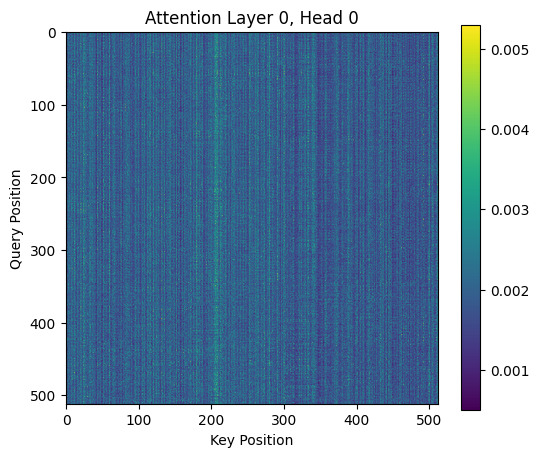

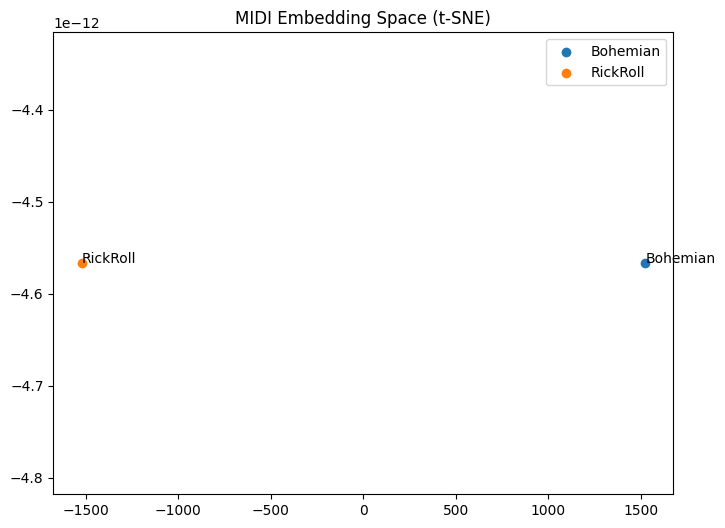

In [ ]:
# 🔧 최초 1회만 실행 (Colab에서)
!pip install transformers miditoolkit scikit-learn matplotlib

# ✅ 필요 모듈
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertConfig, BertModel
import miditoolkit
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from google.colab import files

# 🧠 모델 정의 (마지막 4개 layer 평균 + attention 반환)
class MusicBERTEmbedding(nn.Module):
    def __init__(self, vocab_size=6000):
        super().__init__()
        config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=768,
            num_hidden_layers=4,
            num_attention_heads=8,
            intermediate_size=1024,
            max_position_embeddings=512,
            type_vocab_size=2,
            pad_token_id=0,
            output_hidden_states=True,
            output_attentions=True
        )
        self.encoder = BertModel(config)

    def forward(self, input_ids, attention_mask):
        output = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            output_attentions=True,
            return_dict=True
        )
        hidden_states = output.hidden_states  # (layer, batch, seq_len, hidden)
        last_4 = torch.stack(hidden_states[-4:])  # (4, batch, seq_len, hidden)
        cls_vectors = last_4[:, :, 0, :]  # (4, batch, hidden)
        mean_cls = cls_vectors.mean(dim=0)  # (batch, hidden)
        return mean_cls, output.attentions

# 🧩 MIDI → REMI 토큰 변환
def midi_to_remi_tokens(filepath, max_length=512):
    midi_obj = miditoolkit.midi.parser.MidiFile(filepath)
    events = []
    for track in midi_obj.instruments:
        if track.is_drum:
            continue
        for note in track.notes:
            start = min(int(note.start // 10), 999)
            duration = min(int((note.end - note.start) // 10), 999)
            pitch = note.pitch
            velocity = min(note.velocity, 127)
            events.append((start, duration, pitch, velocity))
    events.sort()

    tokens = []
    for start, duration, pitch, velocity in events:
        tokens.append(1000 + start)      # Time (1000–1999)
        tokens.append(2000 + duration)   # Duration (2000–2999)
        tokens.append(3000 + pitch)      # Pitch (3000–3127)
        tokens.append(4000 + velocity)   # Velocity (4000–4127)

    if len(tokens) > max_length:
        tokens = tokens[:max_length]
    else:
        tokens += [0] * (max_length - len(tokens))

    input_ids = torch.tensor(tokens).unsqueeze(0)
    attention_mask = (input_ids != 0).long()
    return input_ids, attention_mask

# 🔍 Cosine 유사도 계산
def cosine_similarity(vec1, vec2):
    return F.cosine_similarity(vec1, vec2).item()

# 📈 t-SNE 임베딩 시각화
def visualize_embeddings(embeddings, labels):
    embeddings = np.array(embeddings)
    perplexity = min(embeddings.shape[0] - 1, 5)
    reduced = TSNE(n_components=2, perplexity=perplexity).fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    for i, label in enumerate(labels):
        plt.scatter(reduced[i, 0], reduced[i, 1], label=label)
        plt.text(reduced[i, 0] + 0.5, reduced[i, 1], label)
    plt.legend()
    plt.title("MIDI Embedding Space (t-SNE)")
    plt.show()

# 👁️ Self-Attention 시각화
def visualize_attention(attentions, layer=0, head=0):
    attn = attentions[layer][0, head].cpu().numpy()
    plt.figure(figsize=(6, 5))
    plt.imshow(attn, cmap="viridis")
    plt.title(f"Attention Layer {layer}, Head {head}")
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")
    plt.colorbar()
    plt.show()

# 📂 Colab에서 파일 업로드
uploaded = files.upload()

# 🔍 파일명 설정
file1 = "Queen - Bohemian Rhapsody.mid"
file2 = "Never-Gonna-Give-You-Up-3.mid"

# 🧠 모델 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MusicBERTEmbedding(vocab_size=5000).to(device)
model.eval()

# 🎵 MIDI 파일 → 토큰 변환
input_ids_a, mask_a = midi_to_remi_tokens(file1)
input_ids_b, mask_b = midi_to_remi_tokens(file2)
input_ids_a, mask_a = input_ids_a.to(device), mask_a.to(device)
input_ids_b, mask_b = input_ids_b.to(device), mask_b.to(device)

# 🔍 임베딩 추출 + 유사도 계산
with torch.no_grad():
    vec_a, attn_a = model(input_ids_a, mask_a)
    vec_b, attn_b = model(input_ids_b, mask_b)
    score = cosine_similarity(vec_a, vec_b)

print(f"🎼 유사도 점수 (Cosine): {score:.4f} (0 = 다름, 1 = 유사)")

# 👁️ Attention 시각화
visualize_attention(attn_a, layer=0, head=0)

# 📈 임베딩 시각화
embeddings = [
    vec_a.squeeze().cpu().numpy(),
    vec_b.squeeze().cpu().numpy()
]
labels = ["Bohemian", "RickRoll"]
visualize_embeddings(embeddings, labels)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.7 MB/s eta 0:00:00


Saving Never-Gonna-Give-You-Up-3.mid to Never-Gonna-Give-You-Up-3.mid
Saving Pirates of the Caribbean - He's a Pirate (1).mid to Pirates of the Caribbean - He's a Pirate (1).mid
Saving Queen - Bohemian Rhapsody.mid to Queen - Bohemian Rhapsody.mid
Saving youre only lonely L.mid to youre only lonely L.mid


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


🎼 Never-Gonna-Give-You-Up-3.mid vs Pirates of the Caribbean - He's a Pirate (1).mid 유사도 점수: 0.6815
🎼 Never-Gonna-Give-You-Up-3.mid vs Queen - Bohemian Rhapsody.mid 유사도 점수: 0.6841
🎼 Never-Gonna-Give-You-Up-3.mid vs youre only lonely L.mid 유사도 점수: 0.6954


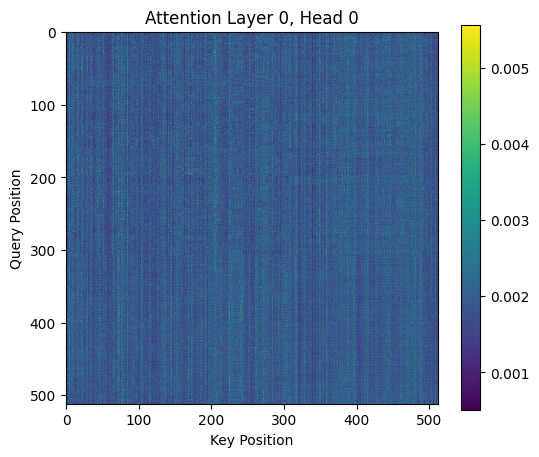

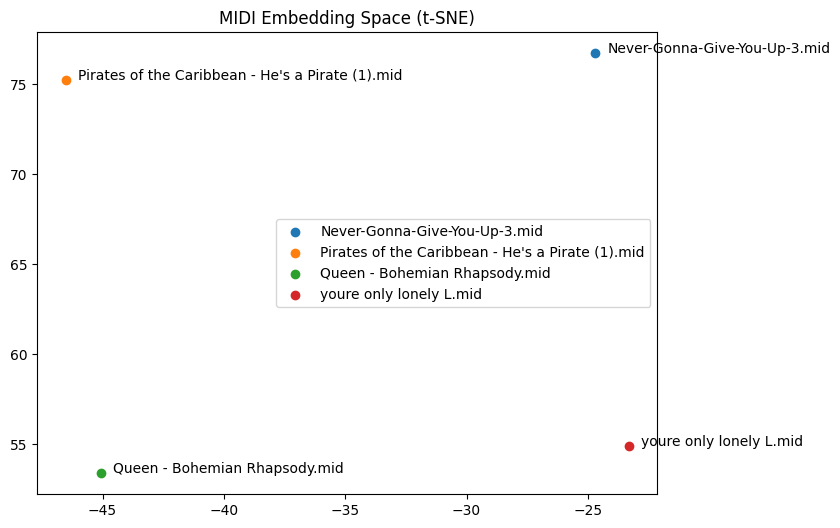

In [ ]:
# 🔧 최초 1회만 실행 (Colab에서)
!pip install transformers miditoolkit scikit-learn matplotlib

# ✅ 필요 모듈
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertConfig, BertModel
import miditoolkit
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from google.colab import files

# 🧠 모델 정의 (마지막 4개 layer 평균 + attention 반환)
class MusicBERTEmbedding(nn.Module):
    def __init__(self, vocab_size=6000):
        super().__init__()
        config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=768,
            num_hidden_layers=4,
            num_attention_heads=8,
            intermediate_size=1024,
            max_position_embeddings=512,
            type_vocab_size=2,
            pad_token_id=0,
            output_hidden_states=True,
            output_attentions=True
        )
        self.encoder = BertModel(config)

    def forward(self, input_ids, attention_mask):
        output = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            output_attentions=True,
            return_dict=True
        )
        hidden_states = output.hidden_states  # (layer, batch, seq_len, hidden)
        last_4 = torch.stack(hidden_states[-4:])  # (4, batch, seq_len, hidden)
        cls_vectors = last_4[:, :, 0, :]  # (4, batch, hidden)
        mean_cls = cls_vectors.mean(dim=0)  # (batch, hidden)
        return mean_cls, output.attentions

# 🧩 MIDI → REMI 토큰 변환
def midi_to_remi_tokens(filepath, max_length=512):
    midi_obj = miditoolkit.midi.parser.MidiFile(filepath)
    events = []
    for track in midi_obj.instruments:
        if track.is_drum:
            continue
        for note in track.notes:
            start = min(int(note.start // 10), 999)
            duration = min(int((note.end - note.start) // 10), 999)
            pitch = note.pitch
            velocity = min(note.velocity, 127)
            events.append((start, duration, pitch, velocity))
    events.sort()

    tokens = []
    for start, duration, pitch, velocity in events:
        tokens.append(1000 + start)
        tokens.append(2000 + duration)
        tokens.append(3000 + pitch)
        tokens.append(4000 + velocity)

    if len(tokens) > max_length:
        tokens = tokens[:max_length]
    else:
        tokens += [0] * (max_length - len(tokens))

    input_ids = torch.tensor(tokens).unsqueeze(0)
    attention_mask = (input_ids != 0).long()
    return input_ids, attention_mask

# 🔍 Cosine 유사도 계산
def cosine_similarity(vec1, vec2):
    return F.cosine_similarity(vec1, vec2).item()

# 📈 t-SNE 임베딩 시각화
def visualize_embeddings(embeddings, labels):
    embeddings = np.array(embeddings)
    perplexity = min(embeddings.shape[0] - 1, 5)
    reduced = TSNE(n_components=2, perplexity=perplexity).fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    for i, label in enumerate(labels):
        plt.scatter(reduced[i, 0], reduced[i, 1], label=label)
        plt.text(reduced[i, 0] + 0.5, reduced[i, 1], label)
    plt.legend()
    plt.title("MIDI Embedding Space (t-SNE)")
    plt.show()

# 👁️ Self-Attention 시각화
def visualize_attention(attentions, layer=0, head=0):
    attn = attentions[layer][0, head].cpu().numpy()
    plt.figure(figsize=(6, 5))
    plt.imshow(attn, cmap="viridis")
    plt.title(f"Attention Layer {layer}, Head {head}")
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")
    plt.colorbar()
    plt.show()

# 📂 Colab에서 다수 파일 업로드
uploaded = files.upload()

# 🔍 비교할 파일 리스트 설정 (file1은 기준, 나머지는 비교 대상)
file_list = list(uploaded.keys())
file1 = file_list[0]
comparison_files = file_list[1:]  # 나머지 파일

# 🧠 모델 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MusicBERTEmbedding(vocab_size=5000).to(device)
model.eval()

# 🎵 기준 MIDI 파일 → 임베딩
input_ids_1, mask_1 = midi_to_remi_tokens(file1)
input_ids_1, mask_1 = input_ids_1.to(device), mask_1.to(device)

with torch.no_grad():
    vec_1, attn_1 = model(input_ids_1, mask_1)

# 🔍 나머지 파일들과 1:N 유사도 비교
for file_n in comparison_files:
    input_ids_n, mask_n = midi_to_remi_tokens(file_n)
    input_ids_n, mask_n = input_ids_n.to(device), mask_n.to(device)
    with torch.no_grad():
        vec_n, _ = model(input_ids_n, mask_n)
        score = cosine_similarity(vec_1, vec_n)
    print(f"🎼 {file1} vs {file_n} 유사도 점수: {score:.4f}")

# 👁️ 기준 파일 Attention 시각화
visualize_attention(attn_1, layer=0, head=0)

# 📈 기준 + 나머지 파일 임베딩 시각화
embeddings = [vec_1.squeeze().cpu().numpy()]
labels = [file1]
for file_n in comparison_files:
    input_ids_n, mask_n = midi_to_remi_tokens(file_n)
    input_ids_n, mask_n = input_ids_n.to(device), mask_n.to(device)
    with torch.no_grad():
        vec_n, _ = model(input_ids_n, mask_n)
    embeddings.append(vec_n.squeeze().cpu().numpy())
    labels.append(file_n)

visualize_embeddings(embeddings, labels)
